In [1]:
%matplotlib widget

from typing import List, Tuple
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 8]

In [2]:

def show_images(images: List[Tuple]) -> None:
    n: int = len(images)
    f = plt.figure()
    # f.set_size_inches(18.5, 10.5)
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i][0], cmap="hot")
        plt.title(images[i][1])
        plt.colorbar(orientation="horizontal")

    plt.show()
    
@njit( parallel = False )
def direct_imaging_w_correction(image, visibilities, uvw_coords, num_uvw_coords, num_channels, image_dim, cell_size_radians, channel_hz_start, bandwidth_increment):
    
    num_visibilities = num_uvw_coords * num_channels
    
    for r in range(image_dim):
        for c in range(image_dim):
           
            pixel_index = r * image_dim + c
            
            x = ((pixel_index % image_dim) - image_dim / 2) * cell_size_radians
            y = ((pixel_index // image_dim) - image_dim / 2) * cell_size_radians
            img_correction = np.sqrt(1.0 - x*x - y*y)
            w_correction = img_correction - 1.0
            pixel_sum = 0.0
            
            for v in range(num_visibilities):
                
                current_baseline = v // num_channels
                current_channel = v % num_channels
                m2w = (channel_hz_start + (bandwidth_increment * current_channel)) / 299792458.0
                uvw = uvw_coords[current_baseline] * m2w
                
                theta = 2.0 * np.pi * (x * uvw[0] + y * uvw[1] + w_correction * uvw[2])
                theta_vis_product = visibilities[v] * (np.cos(theta) + np.sin(theta) * 1.0j)
                pixel_sum += theta_vis_product.real
            
            image[r][c] += pixel_sum * img_correction

In [3]:
# Algorithm parameters
num_receivers = 512
image_dim = 256
fov_degrees = 1.0
channel_start_hz = 140000000.0
channel_bandwidth = 0.0
num_channels = 1
right_ascension = True
num_timesteps = 5

# vis_intensity_file = "datasets/gleam_small/gleam_small.vis"
# vis_uvw_file = "datasets/gleam_small/gleam_small.uvw"
# image_output_file = "datasets/gleam_small/idft_timestep"

vis_intensity_files = ["datasets/gleam_small/gleam_small_ts_{:d}.vis".format(ts) for ts in range(num_timesteps)]
vis_uvw_files = ["datasets/gleam_small/gleam_small_ts_{:d}.uvw".format(ts) for ts in range(num_timesteps)]
image_output_files = ["datasets/gleam_small/idft_ts_{:d}.img".format(ts) for ts in range(num_timesteps)]

render_dim = image_dim
x_render_offset = 0
y_render_offset = 0
num_baselines = (num_receivers * (num_receivers - 1)) // 2
print(num_baselines)
num_uvw_coords = num_baselines
num_visibilities = num_uvw_coords * num_channels
cell_size_radians = np.arcsin(2.0 * np.sin(0.5 * fov_degrees * np.pi / 180.0) / image_dim)

130816


In [4]:
# flip_u_w_coords = -1.0 if right_ascension else 1.0

# uvw_header = np.fromfile(vis_uvw_file, dtype=np.uintc, count=1)
# uvw_coords = np.fromfile(vis_uvw_file, dtype=np.float32, count=3*num_baselines, offset=4)
# uvw_coords = uvw_coords.reshape(num_baselines, 3)
# uvw_coords[:, 0] *= flip_u_w_coords
# uvw_coords[:, 2] *= flip_u_w_coords

# vis_header = np.fromfile(vis_intensity_file, dtype=np.uintc, count=1)
# visibilities = np.fromfile(vis_intensity_file, dtype=np.csingle, count=num_baselines, offset=4)

In [5]:
# bandwidth_increment = 0.0 #channel_bandwidth / (num_channels - 1)
# image = direct_imaging_w_correction(visibilities, uvw_coords, num_uvw_coords, num_channels, image_dim,
#                                     cell_size_radians, channel_start_hz, bandwidth_increment)

In [6]:
# plt.imshow(image)
# plt.colorbar()
# plt.show()

# image.tofile(image_output_files[0])

### Generate _t_ timestep images

Beginning timestep 4...
Getting uvw and vis data...
Synthesizing image for timestep 4...
Saving image to file...


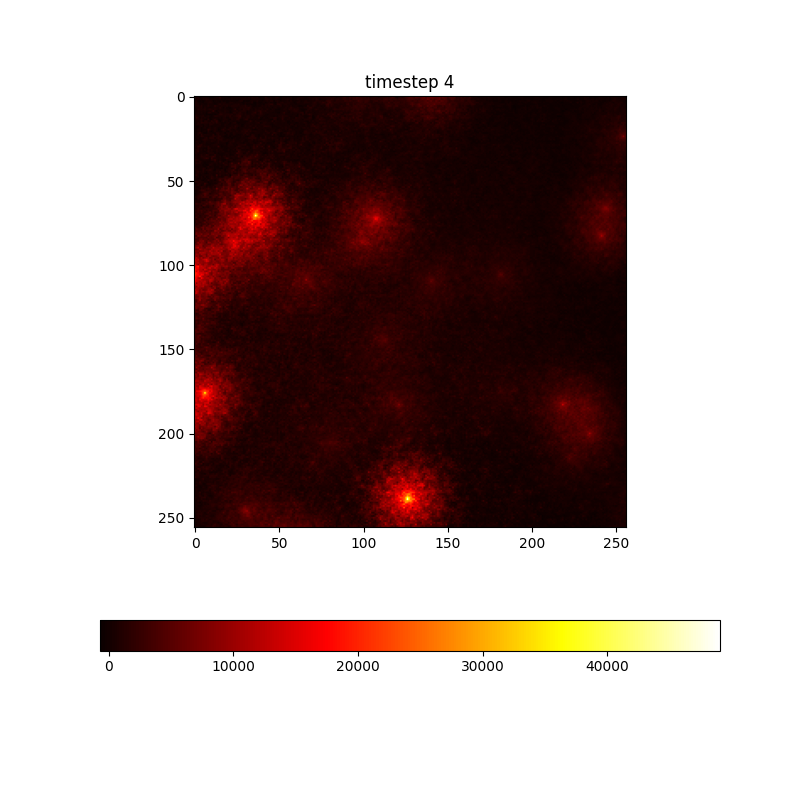

In [7]:
images = []

# all_uvw_coords = np.empty((0, 3), dtype=np.float32)
# all_visibilities = np.empty(0, dtype=np.csingle)

# print(all_uvw_coords.shape)
# print(all_visibilities.shape)

for ts in range(num_timesteps):
    
    print(f"Beginning timestep {ts}...")
    # Populate data from timestep applicable files
    flip_u_w_coords = -1.0 if right_ascension else 1.0
    print("Getting uvw and vis data...")
    uvw_header = np.fromfile(vis_uvw_files[ts], dtype=np.uintc, count=1)
    uvw_coords = np.fromfile(vis_uvw_files[ts], dtype=np.float32, count=3*num_baselines, offset=4)
    uvw_coords = uvw_coords.reshape(num_baselines, 3)
    uvw_coords[:, 0] *= flip_u_w_coords
    uvw_coords[:, 2] *= flip_u_w_coords

    vis_header = np.fromfile(vis_intensity_files[ts], dtype=np.uintc, count=1)
    visibilities = np.fromfile(vis_intensity_files[ts], dtype=np.csingle, count=num_baselines, offset=4)
    
    # all_uvw_coords = np.append(all_uvw_coords, uvw_coords, axis=0)
    # all_visibilities = np.append(all_visibilities, visibilities)
    
    # print(all_uvw_coords.shape)
    # print(all_visibilities.shape)
    
    print(f"Synthesizing image for timestep {ts}...")
    # Produce image
    image = np.zeros((image_dim, image_dim))
    direct_imaging_w_correction(image, visibilities, uvw_coords, num_uvw_coords, num_channels, image_dim, cell_size_radians, channel_start_hz, 0.0)
    
    print("Saving image to file...")
    image.tofile(image_output_files[ts])
    
    images.append((np.copy(image), f"timestep {ts}"))
    
# print("Generating image...")
# image = np.zeros((image_dim, image_dim))
# direct_imaging_w_correction(image, all_visibilities, all_uvw_coords, num_uvw_coords*num_timesteps, num_channels, image_dim, cell_size_radians, channel_start_hz, 0.0)

# image.tofile(image_output_files[ts])
# images.append((image, "IDFT TS 1..5"))
    
show_images(images)